## Brief glance at the main data frame

In [1]:
import pandas as pd
import seaborn as sns

races_df = pd.read_csv("../data/samples/test_sample.csv")

races_df

,Unnamed: 0,race_name,date_time,race_id,place_num,name,number,current_win_odds,current_place_odds,place,...,SumSource_trainer_id_one_constant,SumSource_subject_id_purse,SumSource_jockey_id_purse,SumSource_trainer_id_purse,PreviousValueSource_subject_id_race_date,PreviousValueSource_subject_id_distance_category_race_date,PreviousValueSource_subject_id_jockey_id_race_date,PreviousValueSource_subject_id_track_name_race_date,PreviousValueSource_subject_id_race_class_race_date,PreviousValueSource_subject_id_surface_race_date
0,15,Beverley 1,2023-08-01 15:00:00,6171271,3,Just Hiss,1,9.14,2.59,2,...,777.0,6669.0,981805.0,981805.0,24.0,24.0,32.0,NaN,24.0,24.0
1,27,Beverley 1,2023-08-01 15:00:00,6171271,3,L'es Fremantle,13,643.52,197.79,11,...,26.0,0.0,9651.0,1224.0,13.0,NaN,NaN,NaN,13.0,13.0
2,26,Beverley 1,2023-08-01 15:00:00,6171271,3,Straitouttacompton,12,330.00,80.00,9,...,26.0,753.0,0.0,1224.0,13.0,24.0,24.0,NaN,13.0,13.0
3,25,Beverley 1,2023-08-01 15:00:00,6171271,3,La Forza,11,17.00,4.50,5,...,51.0,1740.0,3893.0,69067.0,13.0,76.0,13.0,NaN,13.0,13.0
4,24,Beverley 1,2023-08-01 15:00:00,6171271,3,Mollies Hope,10,-1.00,0.00,-1,...,29.0,NaN,12002.0,12584.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51853,51847,Wolverhampton 8,2024-03-02 21:30:00,6711804,3,Lord Danielson,2,11.00,0.00,7,...,46.0,1878.0,300656.0,15455.0,22.0,22.0,NaN,NaN,22.0,22.0
51854,51846,Wolverhampton 8,2024-03-02 21:30:00,6711804,3,Sunblock,1,4.20,0.00,1,...,702.0,0.0,1367821.0,2125737.0,35.0,46.0,NaN,71.0,NaN,35.0
51855,51856,Wolverhampton 8,2024-03-02 21:30:00,6711804,3,Clionia,11,15.84,0.00,6,...,964.0,233.0,3961926.0,1802318.0,15.0,15.0,NaN,15.0,15.0,15.0
51856,51850,Wolverhampton 8,2024-03-02 21:30:00,6711804,3,Rust E Boy,5,9.12,0.00,5,...,243.0,3168.0,401781.0,315670.0,15.0,138.0,51.0,15.0,15.0,15.0


In [2]:
races_df[races_df["race_id"] == 6025403]

,Unnamed: 0,race_name,date_time,race_id,n_runners,place_num,name,number,current_win_odds,current_place_odds,...,AverageValueSource_30_10_breeder_win_probability,AverageValueSource_30_10_breeder_momentum,AverageValueSource_30_10_owner_win_probability,AverageValueSource_30_10_owner_momentum,AverageValueSource_30_10_dam_momentum,AverageValueSource_30_10_sire_momentum,PreviousValueSource_subject_id_race_date,PreviousValueSource_subject_id_track_name_race_date,PreviousValueSource_subject_id_race_class_race_date,PreviousValueSource_subject_id_surface_race_date
19609,19692,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Ask Peter,7,5.00,1.51,...,0.124463,926.990290,0.121672,919.930528,901.545241,923.079631,14.0,NaN,14.0,14.0
19610,19690,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,National Charter,5,93.71,10.11,...,0.091835,944.009889,0.047557,918.845189,904.645746,913.976541,21.0,408.0,408.0,21.0
19611,19688,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Glory And Honour,3,4.00,1.36,...,0.226537,954.635282,0.120511,952.011785,951.752997,912.752686,12.0,NaN,34.0,55.0
19612,19686,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Grifter,1,22.20,4.00,...,0.104725,923.258682,NaN,NaN,923.258682,954.715438,25.0,NaN,NaN,25.0
19613,19687,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Absolute Ruler,2,-1.00,0.00,...,0.082245,934.423135,0.073515,969.215005,938.165937,948.829617,8.0,NaN,NaN,8.0
19614,19689,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Crafter,4,-1.00,0.00,...,NaN,NaN,0.089293,947.466985,942.456383,930.648916,13.0,NaN,13.0,13.0
19615,19691,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,Mirrie Dancers,6,2.33,1.25,...,0.067541,929.376909,0.110913,897.912980,920.799243,929.775771,472.0,NaN,472.0,730.0
19616,19693,Wetherby 2,2023-06-06 19:15:00,6025403,8,2,The Resdev Way,8,11.00,2.26,...,0.096649,932.693136,0.062533,911.625006,905.420619,922.229741,1.0,NaN,1.0,1.0


In [1]:
import pandas as pd

races_df = pd.read_csv("../data/leakage_detection/live/2024-01-05.csv")

races_df

,Unnamed: 0,race_name,date_time,race_id,n_runners,place_num,name,number,current_win_odds,current_place_odds,...,MonthCos,MonthSin,DayOfMonthCos,DayOfMonthSin,WeekDaySin,WeekDayCos,PreviousValueSource_subject_id_race_date,PreviousValueSource_subject_id_track_name_race_date,PreviousValueSource_subject_id_race_class_race_date,PreviousValueSource_subject_id_surface_race_date
0,0,Southwell 1,2024-01-05 12:02:00,6572791,12,3,Shine's Ambition,1,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
1,1,Southwell 1,2024-01-05 12:02:00,6572791,12,3,Daafy,2,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
2,2,Southwell 1,2024-01-05 12:02:00,6572791,12,3,Swiss Rowe,3,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
3,3,Southwell 1,2024-01-05 12:02:00,6572791,12,3,Fircombe Hall,4,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
4,4,Southwell 1,2024-01-05 12:02:00,6572791,12,3,Kodebreaker,5,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,186,Wolverhampton 9,2024-01-05 21:30:00,6572808,10,3,South Dakota Sioux,6,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
187,187,Wolverhampton 9,2024-01-05 21:30:00,6572808,10,3,A Pint Of Bear,7,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
188,188,Wolverhampton 9,2024-01-05 21:30:00,6572808,10,3,Camacho Star,8,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN
189,189,Wolverhampton 9,2024-01-05 21:30:00,6572808,10,3,Cailin Saoirse,9,0,0,...,0.866025,0.5,0.528964,0.848644,-0.433884,-0.900969,NaN,NaN,NaN,NaN


{6: 2.054836728993584, 16: 2.0238096223157993, 26: 2.015863678034614, 36: 2.0013034168411705, 46: 2.001607726601993, 56: 1.997443767154918, 66: 1.9764902626766878, 76: 1.9707987553933088, 86: 1.9746465823229622, 96: 1.9687287211418152, 101: 1.9672654586679794}


<AxesSubplot:>

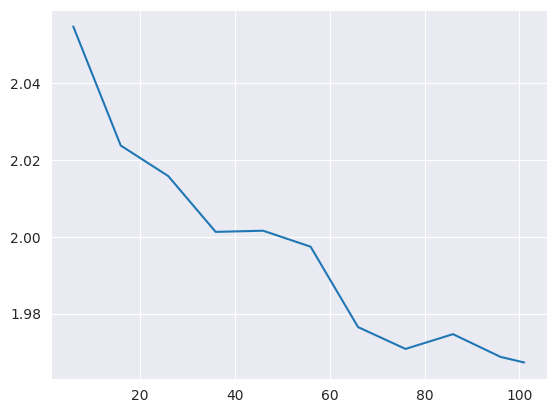

In [8]:
import pickle
import seaborn as sns
from ModelTuning.simulate_conf import LEARNING_CURVE_PATH

with open(LEARNING_CURVE_PATH, "rb") as f:
    learning_curve = pickle.load(f)

print(learning_curve)

sns.lineplot(learning_curve)

## How many horses per race on average?

                 std
year-month          
2023-01     0.569212
2023-02     0.598467
2023-03     0.590859
2023-04     0.577278
2023-05     0.574679
2023-06     0.592172
2023-07     0.511247
2023-08     0.517394
2023-09     0.549343
2023-10     0.530322
2023-11     0.539282
2023-12     0.539895
2024-01     0.529232
2024-02     0.549155
                 std
year-month          
2023-01     2.756486
2023-02     2.655203
2023-03     2.672334
2023-04     2.731561
2023-05     2.716477
2023-06     2.624485
2023-07     2.758634
2023-08     2.788471
2023-09     2.691159
2023-10     2.784613
2023-11     2.784074
2023-12     2.730252
2024-01     2.748570
2024-02     2.666873


<AxesSubplot:xlabel='place_num', ylabel='year-month'>

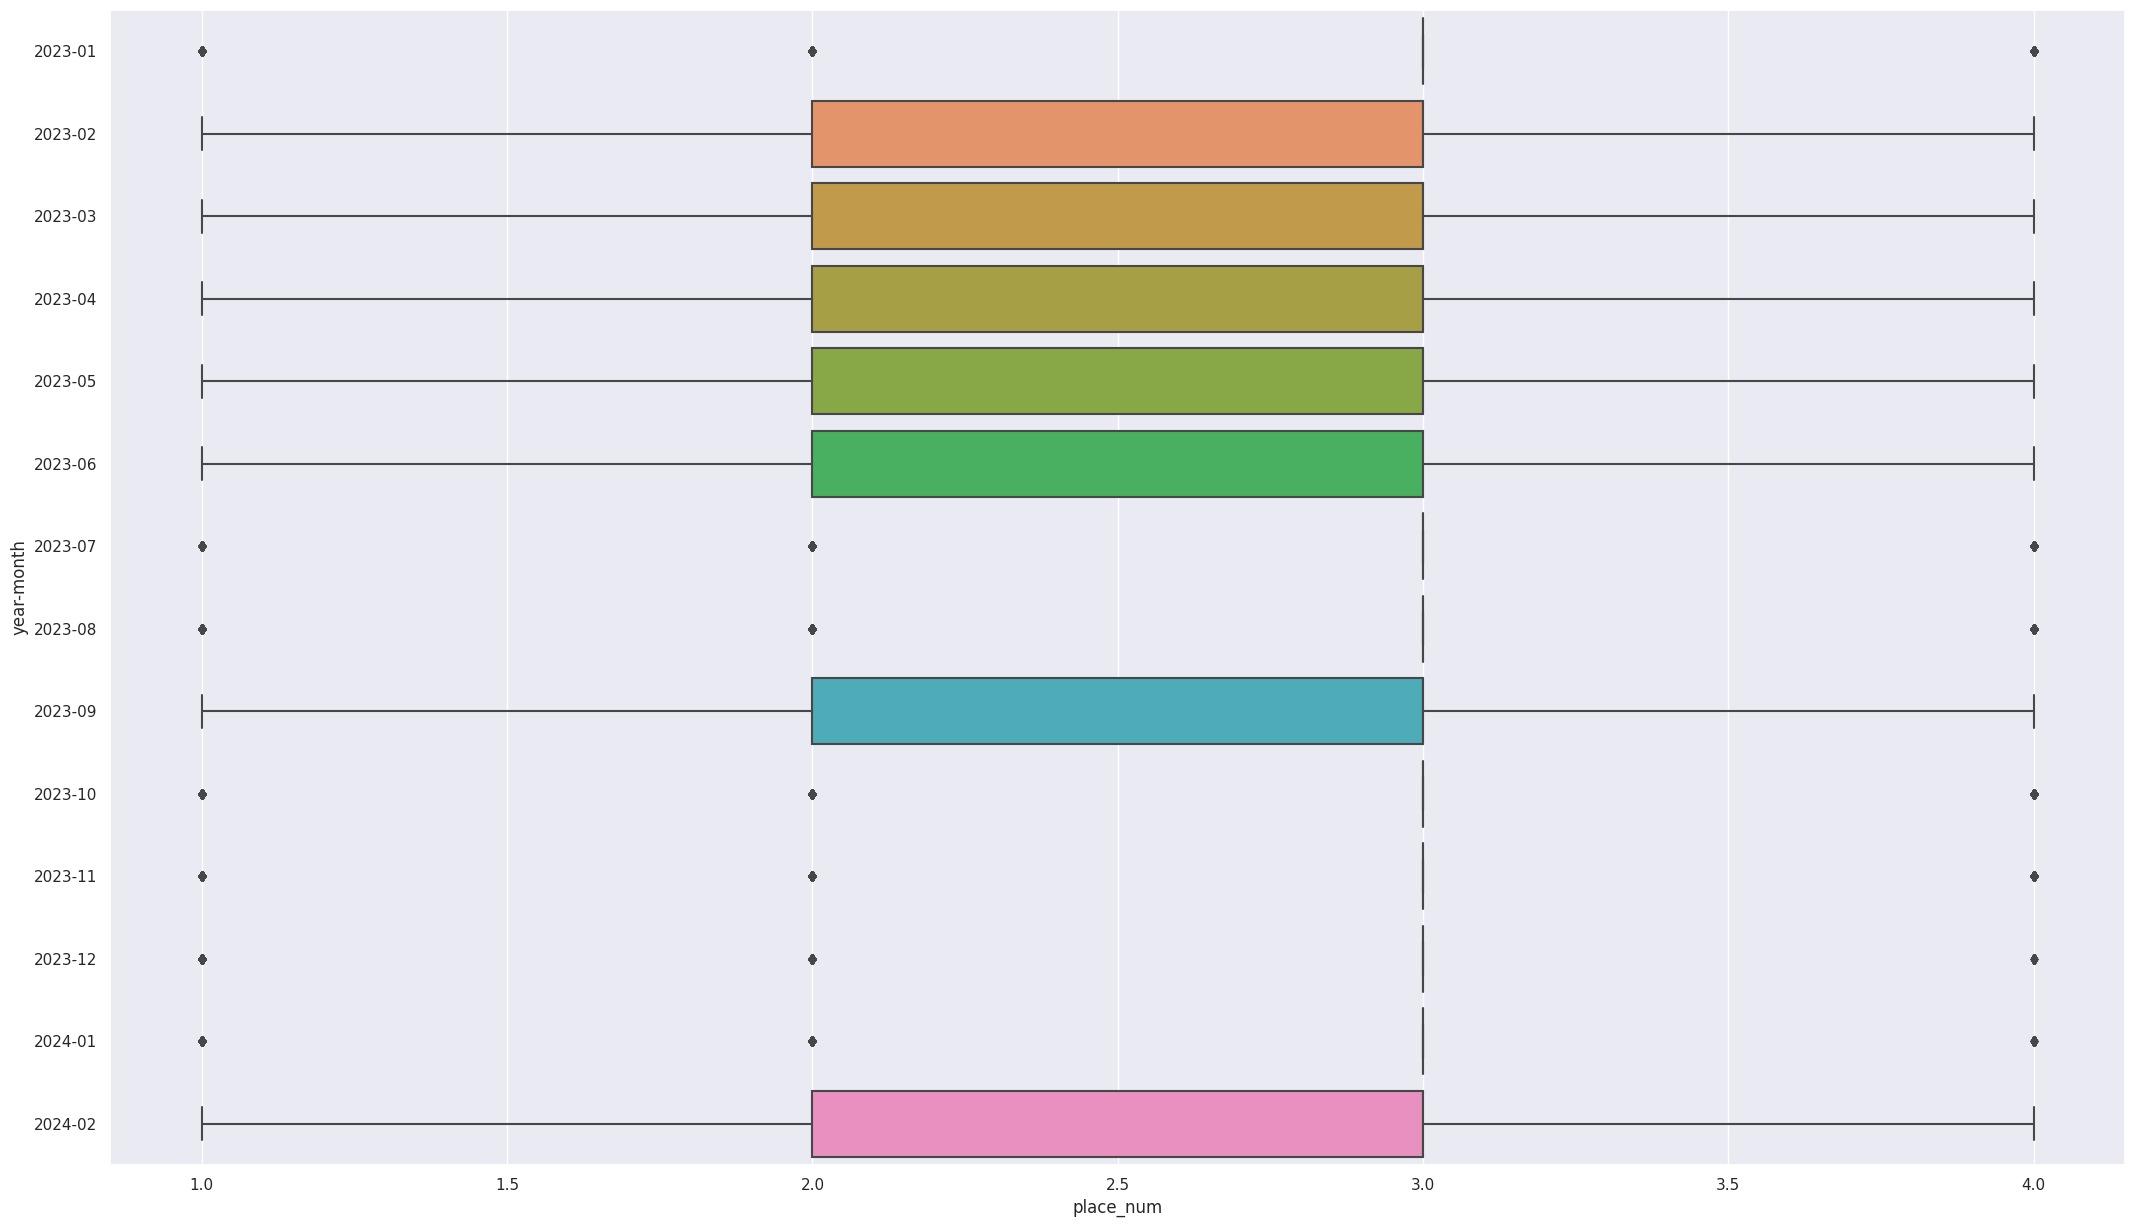

In [6]:
COLUMN_NAME = "place_num"
TIME_INTERVAL = "year-month"

# races_df = races_df[races_df["PreviousWinProbability"] != -1]

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))
print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "mean")))

# races_df_no_rating = races_df[races_df["PreviousWinProbability"] == -1]
# print(races_df_no_rating.groupby([TIME_INTERVAL]).size())

sns.set(rc={'figure.figsize':(26,15)})
sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

In [6]:
avg_horses_per_race = races_df.groupby("race_id").size().mean()

print(f"Average horses per race: {avg_horses_per_race}. Chance to randomly guess the winner: {1 / avg_horses_per_race}")

Average horses per race: 9.3986856516977. Chance to randomly guess the winner: 0.10639785572777065


In [9]:
grouped = races_df.groupby('race_id')

# Use idxmax to get the index of the row with the highest value in each group
max_indexes = grouped['score'].idxmax()

# Use the indexes to extract the rows with the highest values
result_df = races_df.loc[max_indexes]

n_predictions = len(result_df)

n_correct_predictions = len(result_df[result_df["place"] == 1])

print(f"Number of predictions: {n_predictions}")
print(f"Number of correct predictions: {n_correct_predictions}")
print(f"Accuracy: {n_correct_predictions / n_predictions}")

print(result_df)

Number of predictions: 10071
Number of correct predictions: 2470
Accuracy: 0.24525866348922648
        Unnamed: 0  race_name            date_time  race_id  n_runners  \
7              132  Kempton 1  2023-03-01 17:55:00  5779684         11   
21             166  Kempton 2  2023-03-01 18:30:00  5779685         11   
30             175  Kempton 3  2023-03-01 19:00:00  5779686         13   
42             193  Kempton 4  2023-03-01 19:30:00  5779687          9   
52             195  Kempton 5  2023-03-01 20:00:00  5779688          9   
...            ...        ...                  ...      ...        ...   
101393      101275  Newbury 3  2023-12-01 14:15:00  6485188          9   
101402      101285  Newbury 4  2023-12-01 14:50:00  6485189          6   
101411      101297  Newbury 5  2023-12-01 15:25:00  6485190          9   
101422      101304  Newbury 6  2023-12-01 16:00:00  6485191          6   
101426      101307  Newbury 7  2023-12-01 16:35:00  6485192         12   

        place_nu

In [9]:
len(result_df[result_df["label"] == 1]) / len(result_df)

1.0

<AxesSubplot:xlabel='track_name', ylabel='year-month'>

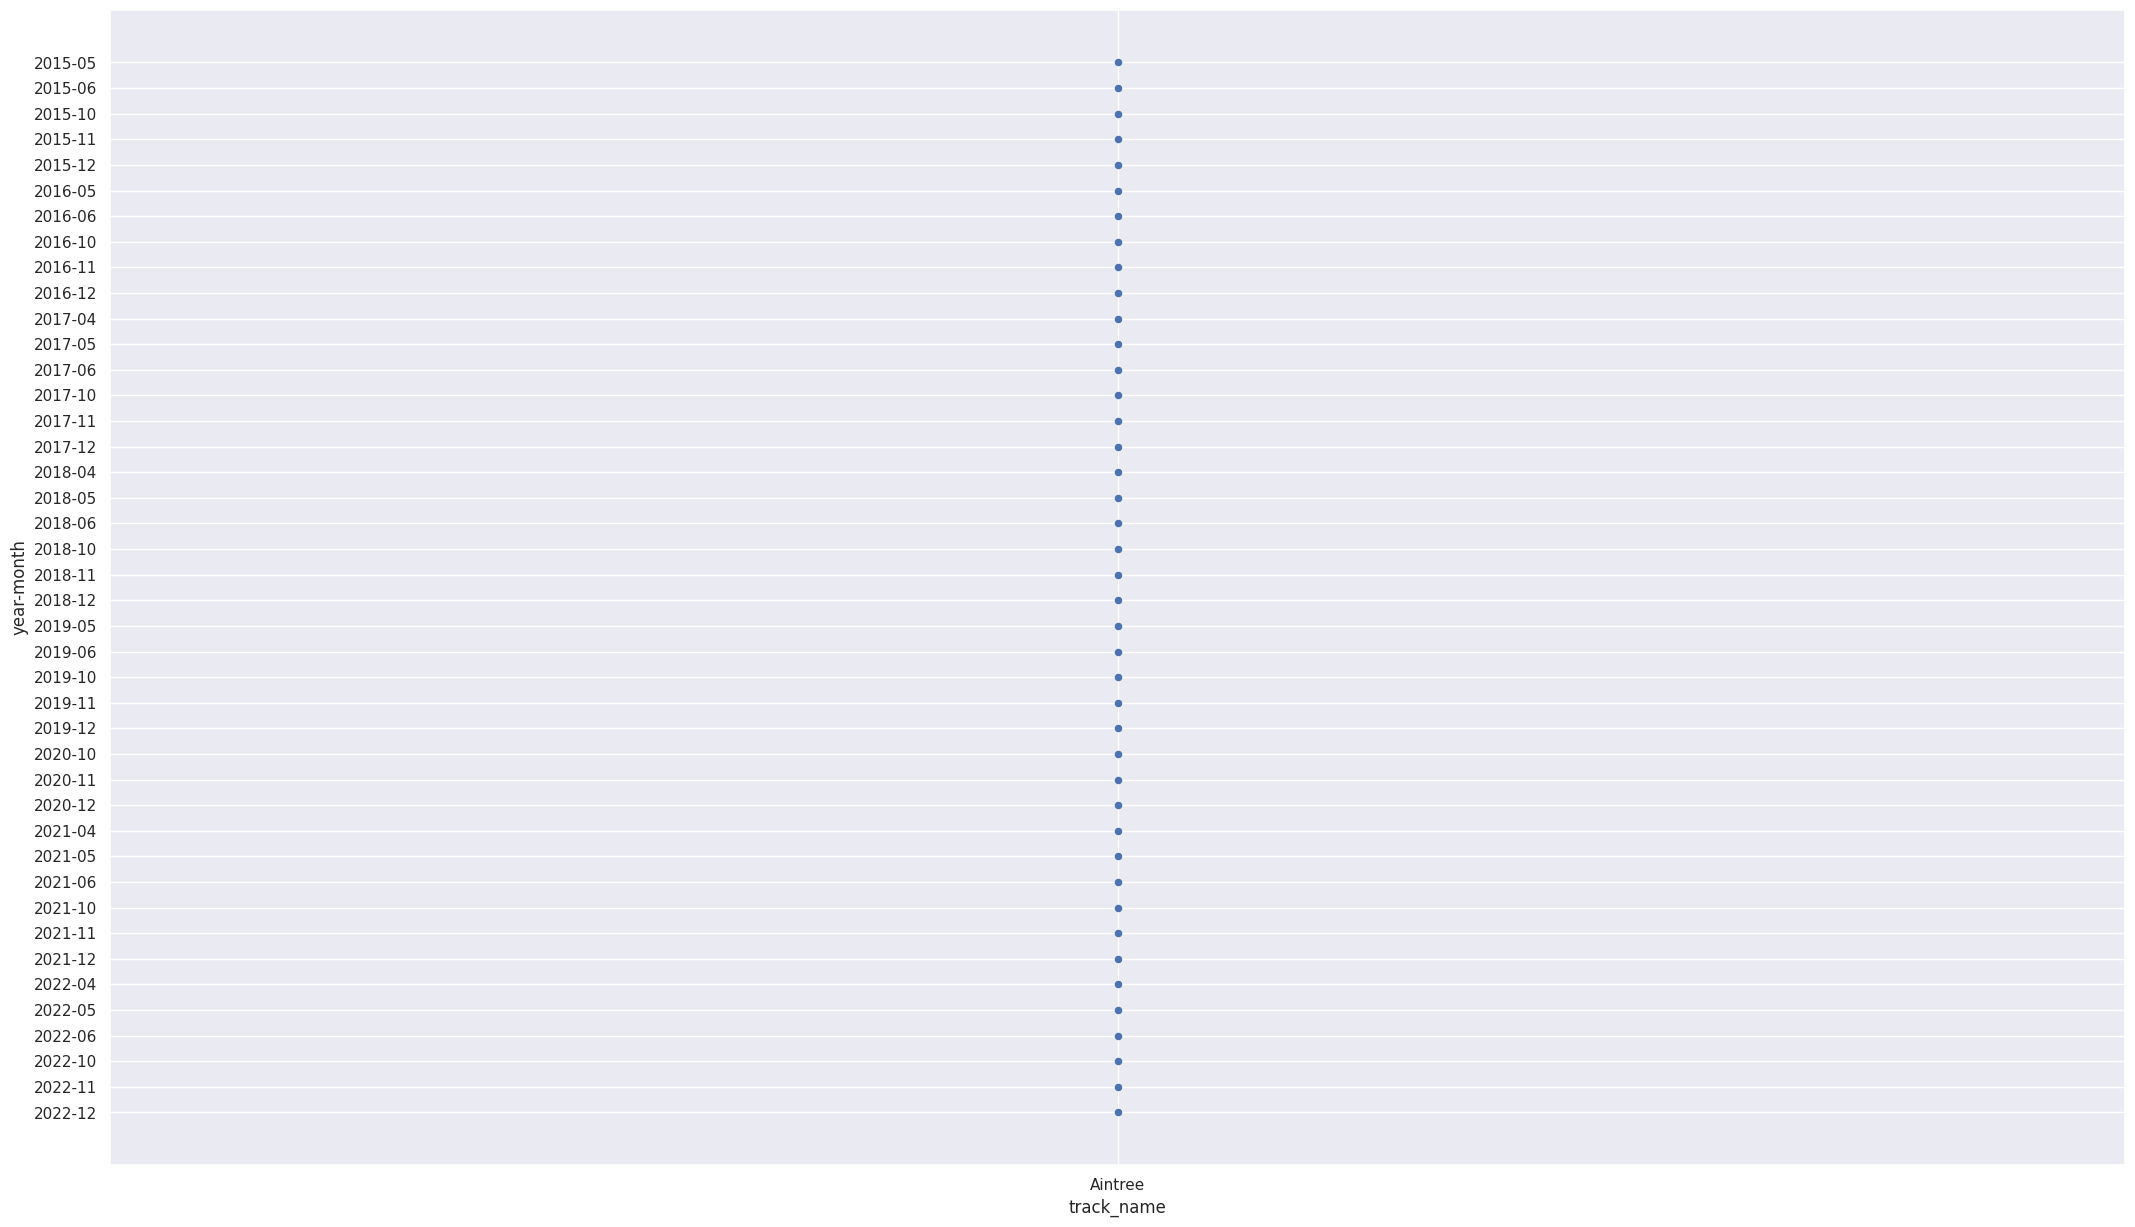

In [38]:
races_df["track_name"] = races_df["race_name"].astype(str).str[:-2]

races_df = races_df[races_df["track_name"] == "Aintree"]
sns.scatterplot(data=races_df, x="track_name", y="year-month")

## Distance Outlier Visualization

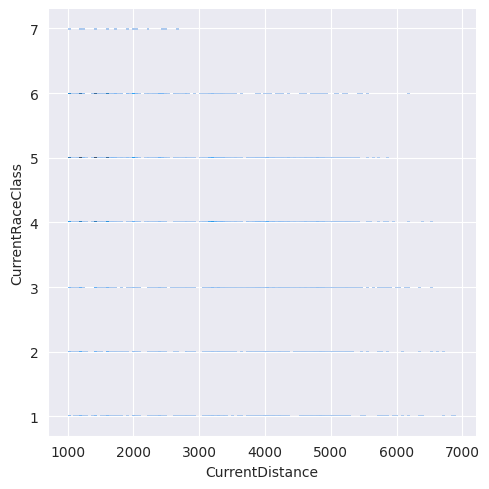

In [4]:
sns.displot(races_df, x="CurrentDistance", y="CurrentRaceClass")

/tmp/ipykernel_16552/1924257147.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distances)


<AxesSubplot:ylabel='Density'>

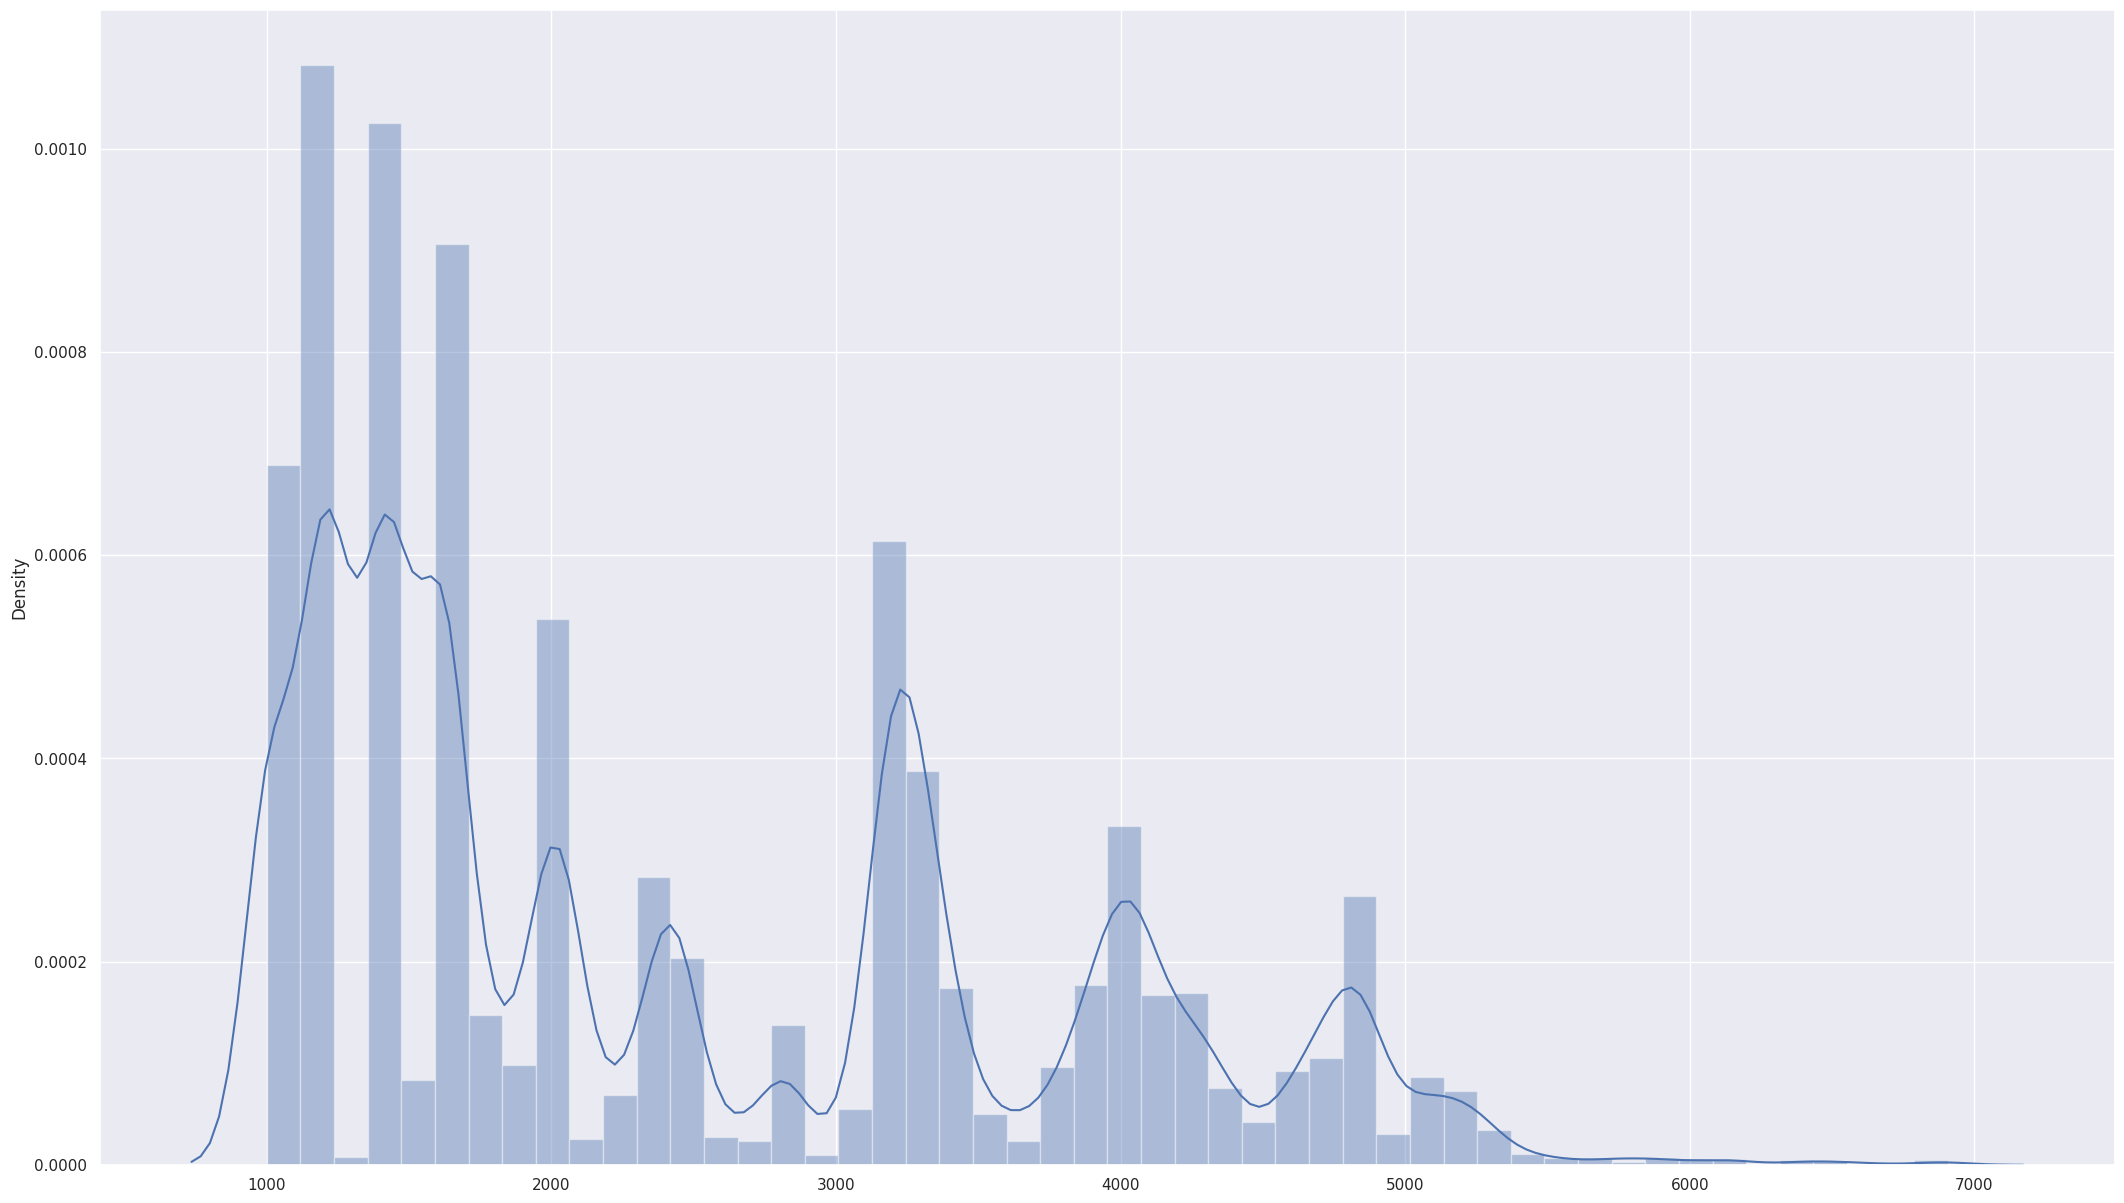

In [11]:
distances = list(races_df["CurrentDistance"].values)

sns.distplot(distances)

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458


## Real time sample inspection

In [1]:
import pandas as pd

real_time_sample_df = pd.read_csv("../data/logs/samples/real_time_5686367")

real_time_sample_df

,Unnamed: 0,race_name,date_time,race_id,n_runners,place_num,name,number,current_estimation_odds,current_betting_odds,...,JockeySurfacePercentageBeaten,JockeyTrackPercentageBeaten,JockeyClassPercentageBeaten,TrainerTrackPercentageBeaten,DistanceDifference,RaceClassDifference,HasTrainerChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Ehteyat,1,2.1,2.37,...,0.516215,0.532121,0.714311,0.749237,337,0.0,0,65.8,0.0,NaN
1,1,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Dance To Paris,2,8.0,6.00,...,0.600373,0.552925,0.753614,0.717757,-44,3.0,0,64.4,0.0,82.0
2,2,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,September Power,3,13.0,10.00,...,0.514251,0.568831,0.459088,0.485482,0,0.0,0,61.2,0.0,71.0
3,3,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,First Emperor,4,19.0,15.00,...,0.497108,0.510266,0.548389,0.383615,0,0.0,0,59.9,0.0,82.0
4,4,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Independence,5,34.0,26.00,...,0.404414,0.281876,0.225695,0.443218,759,0.0,0,59.9,0.0,101.0
5,5,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Smith,6,11.0,9.00,...,0.581062,0.659107,0.708179,0.652143,0,0.0,0,59.9,3.2,65.0
6,6,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Sharp Distinction,7,7.0,8.50,...,0.466521,0.423868,0.537283,0.352511,337,0.0,0,59.0,0.0,75.0
7,7,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Reeceltic,8,9.5,9.00,...,0.565401,0.504532,0.411143,0.471639,-46,-1.0,0,57.6,1.4,62.0
8,8,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Tamaris,9,13.0,19.00,...,0.524641,0.319345,0.494832,0.571220,-395,0.0,0,56.2,0.0,106.0
9,9,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Pledge Of Peace,10,67.0,51.00,...,0.719070,0.567992,0.674015,0.320423,758,-1.0,0,54.9,0.0,68.0


In [ ]:
from tqdm import tqdm
from Persistence.RaceCardPersistence import RaceCardsPersistence

race_cards_persistence = RaceCardsPersistence("race_cards")

for race_card_file_name in tqdm(race_cards_persistence.race_card_file_names):
    race_cards = race_cards_persistence.load_race_card_files_non_writable([race_card_file_name])
    for race_card in race_cards.values():
        print(race_card.date)